In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Inputs import sched_out_trajectories
from datetime import timedelta

In [4]:
# THIS IS HOW TO SHRINK GTFS STOP TIMES
routes_interest= [20]
gtfs_stop_t_df = pd.read_csv('in/raw/gtfs/stop_times.txt') # THIS SHOULD BE THE HEAVY ONE
gtfs_trips_df = pd.read_csv('in/raw/gtfs/trips.txt')
gtfs_trips_df = gtfs_trips_df[gtfs_trips_df['route_id'].isin(routes_interest)]
focus_trip_ids = gtfs_trips_df['trip_id'].unique()
gtfs_stop_t_df = gtfs_stop_t_df[gtfs_stop_t_df['trip_id'].isin(focus_trip_ids)]
gtfs_stop_t_df.to_csv('in/raw/gtfs/stop_times2.txt', index=False)

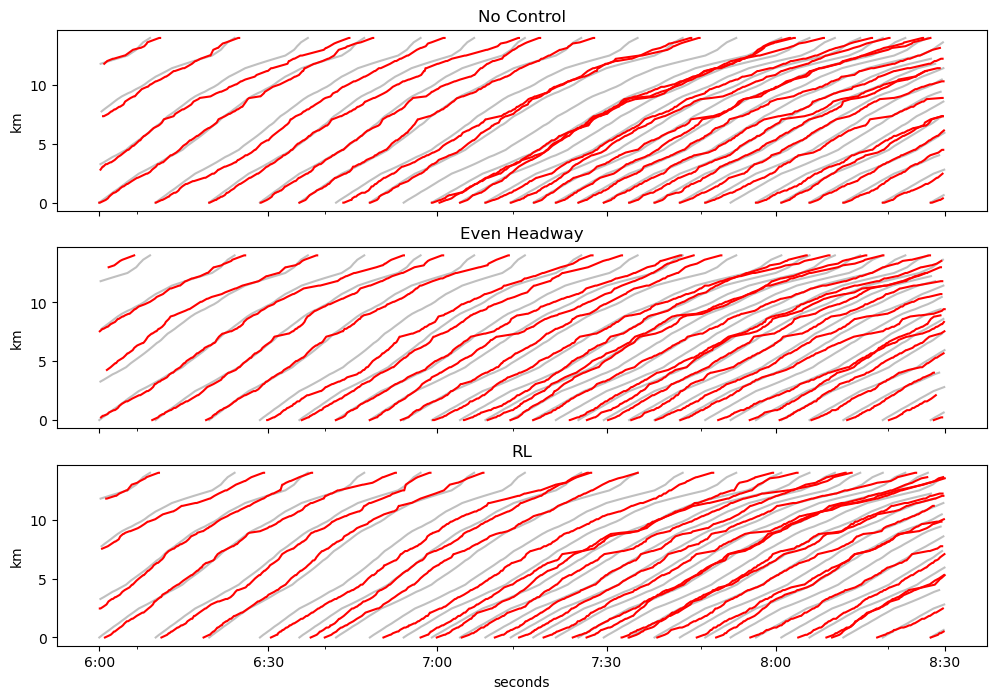

In [8]:
# THIS IS HOW TO CREATE TRAJECTORY PLOTS
titles = ['No Control', 'Even Headway', 'RL']
scenarios = ['NC_dispatch', 'EH_dispatch', 'RL_dispatch']
day = '0629'
tstamp = ['175306','175309', '175312']
replication = 1
time_period = (6*60*60, int(8.5*60*60))
fig, axs = plt.subplots(nrows=len(tstamp), sharex='all', figsize=(12,8))

df_sched_t_rep = pd.DataFrame(sched_out_trajectories, columns=['trip_id', 'schd_sec', 'dist_traveled'])
df_sched_t_rep['dist_traveled'] = df_sched_t_rep['dist_traveled'] / 3281
df_sched_t_rep = df_sched_t_rep[(df_sched_t_rep['schd_sec'] >= time_period[0]) & (df_sched_t_rep['schd_sec'] <= time_period[1])]
df_sched_t_rep = df_sched_t_rep.set_index('schd_sec')
for i in range(len(tstamp)):
    df_out = pd.read_pickle('out/' + scenarios[i] + '/' + day + '-' + tstamp[i] + '-trip_record_outbound.pkl')
    df_arr_t = df_out[['trip_id', 'replication', 'dist_traveled', 'arr_sec']].copy()
    df_arr_t = df_arr_t.rename(columns={'arr_sec': 'seconds'})
    df_dep_t = df_out[['trip_id', 'replication', 'dist_traveled', 'dep_sec']].copy()
    df_dep_t = df_dep_t.rename(columns={'dep_sec': 'seconds'})
    
    df_times = pd.concat([df_arr_t, df_dep_t], axis=0, ignore_index=True)
    df_times['dist_traveled'] = df_times['dist_traveled']/3281
    df_times = df_times.sort_values(by=['trip_id', 'seconds'])

    df_times_rep = df_times[df_times['replication'] == replication].copy()

    df_times_rep = df_times_rep[(df_times_rep['seconds'] >= time_period[0]) & (df_times_rep['seconds'] <= time_period[1])]
    df_times_rep = df_times_rep.set_index('seconds')
    
    df_sched_t_rep.groupby('trip_id')['dist_traveled'].plot(color='silver', ax=axs[i])
    df_times_rep.groupby('trip_id')['dist_traveled'].plot(color='red', ax=axs[i])
    axs[i].set_title(titles[i])
    axs[i].set_ylabel('km')
x_ticks = [x for x in range(time_period[0], time_period[1]+30*60, 30*60)]
x_labels = [str(timedelta(seconds=round(x)))[:-3] for x in x_ticks]
plt.xticks(ticks=x_ticks, labels=x_labels)
plt.show()

In [11]:
from Inputs import STOPS_OUT_FULL_PATT
from Input_Processor import remove_outliers

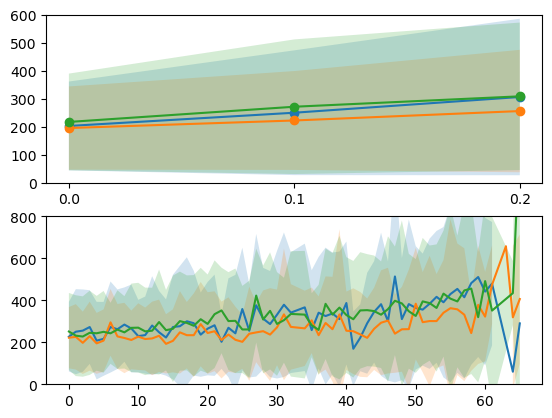

In [12]:
scenarios = ['NC_dispatch', 'EH_dispatch', 'RL_dispatch']
tstamps1 = ['175037', '175046', '175306']
tstamps2 = ['175040', '175049', '175309']
tstamps3 = ['175043', '175052', '175312']
day = '0629'
prob_cancel = [0.0, 0.1, 0.2]
time_period = (6*60*60, int(8.5*60*60))
wt1 = []
wt1s = []
wt1_per_stop = [[] for _ in tstamps1]
wt1_per_stop_sd = [[] for _ in tstamps1]

for i in range(len(tstamps1)):
    df_pax = pd.read_pickle('out/' + scenarios[0] + '/' + day + '-' + tstamps1[i] + '-pax_record.pkl')
    df_pax = df_pax[(df_pax['arr_time']<=time_period[1]) & (df_pax['arr_time']>=time_period[0])]
    df_pax['wt'] = df_pax['board_time'] - df_pax['arr_time']
    wt = df_pax['wt']
    wt1.append(wt.mean())
    wt1s.append(wt.std())
    for s in STOPS_OUT_FULL_PATT:
        wt = df_pax[df_pax['orig_idx'] == s]['wt']
        wt1_per_stop[i].append(wt.mean())
        wt1_per_stop_sd[i].append(wt.std())

wt2 = []
wt2s = []    
wt2_per_stop = [[] for _ in tstamps2]
wt2_per_stop_sd = [[] for _ in tstamps2]
for i in range(len(tstamps2)):
    df_pax = pd.read_pickle('out/' + scenarios[1] + '/' + day + '-' + tstamps2[i] + '-pax_record.pkl')
    df_pax = df_pax[(df_pax['arr_time']<=time_period[1]) & (df_pax['arr_time']>=time_period[0])]
    df_pax['wt'] = df_pax['board_time'] - df_pax['arr_time']
    wt = df_pax['wt']
    wt2.append(wt.mean())
    wt2s.append(wt.std())
    for s in STOPS_OUT_FULL_PATT:
        wt = df_pax[df_pax['orig_idx'] == s]['wt']
        wt2_per_stop[i].append(wt.mean())
        wt2_per_stop_sd[i].append(wt.std())

wt3 = []
wt3s = []    
wt3_per_stop = [[] for _ in tstamps3]
wt3_per_stop_sd = [[] for _ in tstamps3]
for i in range(len(tstamps3)):
    df_pax = pd.read_pickle('out/' + scenarios[2] + '/' + day + '-' + tstamps3[i] + '-pax_record.pkl')
    df_pax = df_pax[(df_pax['arr_time']<=time_period[1]) & (df_pax['arr_time']>=time_period[0])]
    df_pax['wt'] = df_pax['board_time'] - df_pax['arr_time']
    wt = df_pax['wt']
    wt3.append(wt.mean())
    wt3s.append(wt.std())
    for s in STOPS_OUT_FULL_PATT:
        wt = df_pax[df_pax['orig_idx'] == s]['wt']
        wt3_per_stop[i].append(wt.mean())
        wt3_per_stop_sd[i].append(wt.std())
        
plt.close()
fig, axs = plt.subplots(nrows=2)
axs[0].plot(prob_cancel, wt1, marker='o')
axs[0].fill_between(prob_cancel, np.array(wt1)-np.array(wt1s), np.array(wt1)+np.array(wt1s), alpha=0.2)
axs[0].plot(prob_cancel, wt2, marker='o')
axs[0].fill_between(prob_cancel, np.array(wt2)-np.array(wt2s), np.array(wt2)+np.array(wt2s), alpha=0.2)
axs[0].plot(prob_cancel, wt3, marker='o')
axs[0].fill_between(prob_cancel, np.array(wt3)-np.array(wt3s), np.array(wt3)+np.array(wt3s), alpha=0.2)
axs[0].set_xticks(prob_cancel)
axs[0].set_ylim(0,600)
stops_x = np.arange(len(STOPS_OUT_FULL_PATT))

wt = np.array(wt1_per_stop[-1])
wts = np.array(wt1_per_stop_sd[-1])
wt_nona = wt[~np.isnan(wt)]
wts = wts[~np.isnan(wt)]
axs[1].plot(stops_x[~np.isnan(wt)], wt_nona)
axs[1].fill_between(stops_x[~np.isnan(wt)], wt_nona-wts, wt_nona+wts, alpha=0.2)
wt = np.array(wt2_per_stop[-1])
wts = np.array(wt2_per_stop_sd[-1])
wt_nona = wt[~np.isnan(wt)]
wts = wts[~np.isnan(wt)]
axs[1].plot(stops_x[~np.isnan(wt)], wt_nona)
axs[1].fill_between(stops_x[~np.isnan(wt)], wt_nona-wts, wt_nona+wts, alpha=0.2)
axs[1].set_ylim(0, 800)
wt = np.array(wt3_per_stop[-1])
wts = np.array(wt3_per_stop_sd[-1])
wt_nona = wt[~np.isnan(wt)]
wts = wts[~np.isnan(wt)]
axs[1].plot(stops_x[~np.isnan(wt)], wt_nona)
axs[1].fill_between(stops_x[~np.isnan(wt)], wt_nona-wts, wt_nona+wts, alpha=0.2)
axs[1].set_ylim(0, 800)
plt.show()

In [14]:
from Output_Processor import cv_hw_by_time
from Inputs import STOPS_OUT_FULL_PATT

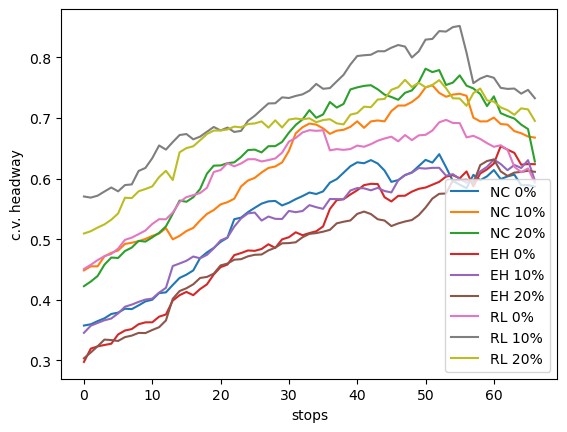

In [15]:
scenarios = ['NC_dispatch', 'EH_dispatch', 'RL_dispatch']
tstamps1 = ['175037', '175046', '175306']
tstamps2 = ['175040', '175049', '175309']
tstamps3 = ['175043', '175052', '175312']
day = '0629'
prob_cancel = ['0%', '10%', '20%']
time_period = (6*60*60, int(8.5*60*60))
plt.close()
fig, ax = plt.subplots()
for i in range(len(tstamps1)):
    df_out = pd.read_pickle('out/' + scenarios[0] + '/' + day + '-' + tstamps1[i] + '-trip_record_outbound.pkl')
    cv = cv_hw_by_time(df_out, time_period[0], time_period[1], STOPS_OUT_FULL_PATT)
    ax.plot(np.arange(len(STOPS_OUT_FULL_PATT)), cv, label='NC ' + prob_cancel[i])
for i in range(len(tstamps2)):
    df_out = pd.read_pickle('out/' + scenarios[1] + '/' + day + '-' + tstamps2[i] + '-trip_record_outbound.pkl')
    cv = cv_hw_by_time(df_out, time_period[0], time_period[1], STOPS_OUT_FULL_PATT)
    ax.plot(np.arange(len(STOPS_OUT_FULL_PATT)), cv, label='EH ' + prob_cancel[i])
for i in range(len(tstamps3)):
    df_out = pd.read_pickle('out/' + scenarios[2] + '/' + day + '-' + tstamps3[i] + '-trip_record_outbound.pkl')
    cv = cv_hw_by_time(df_out, time_period[0], time_period[1], STOPS_OUT_FULL_PATT)
    ax.plot(np.arange(len(STOPS_OUT_FULL_PATT)), cv, label='RL ' + prob_cancel[i])
plt.ylabel('c.v. headway')
plt.xlabel('stops')
plt.legend()
plt.show()